<a href="https://colab.research.google.com/github/takman99/Stock-Market-Prediction-Using-LSTM-and-GRU-Neural-Networks/blob/main/GRU_Single_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU Model



In [ ]:
# Importing libraries
!pip install yfinance --upgrade --no-cache-dir
!pip install --upgrade pandas
!pip install pycryptodome pycryptodomex
!pip uninstall --yes pandas-datareader
!pip install git+https://github.com/raphi6/pandas-datareader.git@ea66d6b981554f9d0262038aef2106dda7138316
!pip install scikit-optimize
import math
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader as web
import tensorflow as tf
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
from keras.activations import relu, tanh, linear
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.22
    Uninstalling yfinance-0.2.22:
      Successfully uninstalled yfinance-0.2.22
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 97.5 MB/s eta 0:00:00
Found existing in

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = yf.download("^GSPC", start="2000-01-03", end="2016-11-10")


# Selecting the 6 input features
data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset = data.values

training_data_len = len(dataset) - 400

# Fitting the MinMaxScaler only on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset[:training_data_len])

# Transforming both the training and test data using the fitted scaler
scaled_data = scaler.transform(dataset)

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, :])
    y_train.append(train_data[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))

#Test data
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, 3]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Determining the index where the validation set should start
validation_start_index = int(x_train.shape[0] * 0.8)

# Splitting the training data into training and validation sets
x_train, x_val = x_train[:validation_start_index], x_train[validation_start_index:]
y_train, y_val = y_train[:validation_start_index], y_train[validation_start_index:]


def gru_model_optimize(params):
    learning_rate, epochs, batch_size, dropout, activation_function, optimizer, neurons_1, neurons_3, neurons_4, l2_lambda = params

    model = Sequential()
    model.add(GRU(neurons_1, return_sequences=False, input_shape=(x_train.shape[1], 6), activation=activation_function, kernel_regularizer=L2(l2_lambda)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons_3, activation=activation_function))
    model.add(Dense(neurons_4))

    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])


    predictions = model.predict(x_val)
    predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
    predicted_data[:, 3] = predictions[:, 0]
    predictions = scaler.inverse_transform(predicted_data)[:, 3]


    # Inverse transform y_val
    y_val_unscaled_data = np.zeros((y_val.shape[0], dataset.shape[1]))
    y_val_unscaled_data[:, 3] = y_val
    y_val_unscaled = scaler.inverse_transform(y_val_unscaled_data)[:, 3]

    mse = np.mean(((predictions - y_val_unscaled) ** 2))

    rmse = np.sqrt(np.mean(((predictions - y_val_unscaled) ** 2)))
    print('rmse=', rmse)
    #Checking if MSE is "nan" and return a large value if it is
    if np.isnan(mse):
        return 1e6  # Replace with a large value of your choice
    else:
      return mse


# Defining the search space for hyperparameters
space = [
    Categorical([0.0001, 0.001, 0.01, 0.1], name="learning_rate"),
    Categorical([100, 200, 300, 400, 500,1000], name="epochs"),
    Categorical([8, 16, 32, 64], name="batch_size"),
    Categorical([0.1, 0.2, 0.3, 0.4, 0.5], name="dropout"),
    Categorical(['tanh', 'sigmoid','relu'], name="activation_function"),
    Categorical([Adam, RMSprop, Adagrad], name="optimizer"),
    Categorical([60, 80, 100, 120, 140, 160, 180], name="neurons_1"),
    Integer(15, 30, name="neurons_3"),
    Integer(1, 10, name="neurons_4"),
    Categorical([0.0005, 0.0001, 0.00005, 0.00001], name="l2_lambda"),

]


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Performing Bayesian optimization using gp_minimize
result = gp_minimize(gru_model_optimize, space, n_calls=20, n_random_starts=10, verbose=1, n_jobs=-1)

# Extracting the optimal hyperparameters
opt_learning_rate, opt_epochs, opt_batch_size, opt_dropout, opt_activation_function, opt_optimizer, opt_neurons_1, opt_neurons_3, opt_neurons_4, opt_l2_lambda = result.x

# Training the GRU model with the optimal hyperparameters
model = Sequential()
model.add(GRU(opt_neurons_1, return_sequences=False, input_shape=(x_train.shape[1], 6), activation=opt_activation_function, kernel_regularizer=L2(opt_l2_lambda)))
model.add(Dropout(opt_dropout))
model.add(Dense(opt_neurons_3, activation=opt_activation_function))
model.add(Dense(opt_neurons_4))

opt = opt_optimizer(learning_rate=opt_learning_rate)
model.compile(optimizer=opt, loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=opt_batch_size, epochs=opt_epochs, verbose=1, callbacks=[early_stopping])

predictions = model.predict(x_test)
predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
predicted_data[:, 3] = predictions[:, 0]
predictions = scaler.inverse_transform(predicted_data)[:, 3]


# Calculating Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('rmse= ' + str(rmse))

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('mae= ' + str(mae))


#Calculating Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predictions - y_test) / y_test)) * 100
print('mape= ' + str(mape))

# Calculating Adjusted Mean Absolute Percentage Error (AMAPE)
amape = np.mean(np.abs((predictions - y_test) / np.mean(y_test))) * 100
print('amape= ' + str(amape))


print("Optimal learning rate:", opt_learning_rate)
print("Optimal epochs:", opt_epochs)
print("Optimal batch size:", opt_batch_size)
print("Optimal dropout rate:", opt_dropout)
print("Optimal activation function:", opt_activation_function)
print("Optimal optimizer:", opt_optimizer.__name__)
print("Optimal neurons for the first GRU layer:", opt_neurons_1)
print("Optimal Dense neuron 1:", opt_neurons_3)
print("Optimal Dense neuron 2:", opt_neurons_4)
print("L2 regularization lambda:", opt_l2_lambda)


Iteration No: 1 started. Evaluating function at random point.
Epoch 1/200
95/95 [==============================] - 2s 9ms/step - loss: 0.0688 - val_loss: 0.0556
Epoch 2/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0472 - val_loss: 0.0448
Epoch 3/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.0371
Epoch 4/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0338 - val_loss: 0.0312
Epoch 5/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0289 - val_loss: 0.0267
Epoch 6/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0246 - val_loss: 0.0229
Epoch 7/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0212 - val_loss: 0.0194
Epoch 8/200
95/95 [==============================] - 0s 5ms/step - loss: 0.0183 - val_loss: 0.0166
Epoch 9/200
95/95 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 10/200
95/95 [===========================

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/300
379/379 [==============================] - 4s 6ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 2/300
379/379 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/300
379/379 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 4/300
379/379 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/300
379/379 [==============================] - 2s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 6/300
379/379 [==============================] - 2s 5ms/step - loss: 9.4132e-04 - val_loss: 0.0010
Epoch 7/300
379/379 [==============================] - 2s 5ms/step - loss: 8.2957e-04 - val_loss: 6.6097e-04
Epoch 8/300
379/379 [==============================] - 2s 5ms/step - loss: 8.0860e-04 - val_loss: 7.3207e-04
Epoch 9/300
379/379 [==============================] - 2s 5ms/step - loss: 7.5524e-04 - val_loss: 8.0769e-04
Epoch 10/300
379/379 [==============================] - 2s 5ms/

379/379 [==============================] - 3s 5ms/step - loss: 0.0043
Epoch 2/300
376/379 [============================>.] - ETA: 0s - loss: 0.0018

379/379 [==============================] - 2s 4ms/step - loss: 0.0018
Epoch 3/300
373/379 [============================>.] - ETA: 0s - loss: 0.0013

379/379 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 4/300
373/379 [============================>.] - ETA: 0s - loss: 9.9654e-04

379/379 [==============================] - 2s 4ms/step - loss: 9.9683e-04
Epoch 5/300
373/379 [============================>.] - ETA: 0s - loss: 8.8697e-04

379/379 [==============================] - 2s 4ms/step - loss: 8.8748e-04
Epoch 6/300
371/379 [============================>.] - ETA: 0s - loss: 8.5150e-04

379/379 [==============================] - 2s 4ms/step - loss: 8.5173e-04
Epoch 7/300
372/379 [============================>.] - ETA: 0s - loss: 7.6059e-04

379/379 [==============================] - 2s 4ms/step - loss: 7.5820e-04
Epoch 8/300
369/379 [============================>.] - ETA: 0s - loss: 7.5351e-04

379/379 [==============================] - 2s 4ms/step - loss: 7.5491e-04
Epoch 9/300
379/379 [==============================] - ETA: 0s - loss: 7.1700e-04

379/379 [==============================] - 2s 4ms/step - loss: 7.1700e-04
Epoch 10/300
374/379 [============================>.] - ETA: 0s - loss: 6.8536e-04

379/379 [==============================] - 2s 4ms/step - loss: 6.8368e-04
Epoch 11/300
373/379 [============================>.] - ETA: 0s - loss: 6.4251e-04

379/379 [==============================] - 2s 4ms/step - loss: 6.4096e-04
Epoch 12/300
373/379 [============================>.] - ETA: 0s - loss: 6.5121e-04

379/379 [==============================] - 2s 4ms/step - loss: 6.5429e-04
Epoch 13/300
373/379 [============================>.] - ETA: 0s - loss: 6.0584e-04

379/379 [==============================] - 2s 4ms/step - loss: 6.0439e-04
Epoch 14/300
372/379 [============================>.] - ETA: 0s - loss: 5.6698e-04

379/379 [==============================] - 2s 4ms/step - loss: 5.6614e-04
Epoch 15/300
373/379 [============================>.] - ETA: 0s - loss: 5.4358e-04

379/379 [==============================] - 2s 4ms/step - loss: 5.4503e-04
Epoch 16/300
378/379 [============================>.] - ETA: 0s - loss: 5.3378e-04

379/379 [==============================] - 2s 4ms/step - loss: 5.3376e-04
Epoch 17/300
374/379 [============================>.] - ETA: 0s - loss: 5.4062e-04

379/379 [==============================] - 2s 5ms/step - loss: 5.4167e-04
Epoch 18/300
372/379 [============================>.] - ETA: 0s - loss: 5.0464e-04

379/379 [==============================] - 2s 4ms/step - loss: 5.0407e-04
Epoch 19/300
373/379 [============================>.] - ETA: 0s - loss: 4.8533e-04

379/379 [==============================] - 2s 4ms/step - loss: 4.8575e-04
Epoch 20/300
373/379 [============================>.] - ETA: 0s - loss: 4.6361e-04

379/379 [==============================] - 2s 4ms/step - loss: 4.6329e-04
Epoch 21/300
373/379 [============================>.] - ETA: 0s - loss: 4.4194e-04

379/379 [==============================] - 2s 4ms/step - loss: 4.4166e-04
Epoch 22/300
373/379 [============================>.] - ETA: 0s - loss: 4.3007e-04

379/379 [==============================] - 2s 4ms/step - loss: 4.2907e-04
Epoch 23/300
373/379 [============================>.] - ETA: 0s - loss: 4.1112e-04

379/379 [==============================] - 2s 4ms/step - loss: 4.1068e-04
Epoch 24/300
376/379 [============================>.] - ETA: 0s - loss: 3.9759e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.9888e-04
Epoch 25/300
374/379 [============================>.] - ETA: 0s - loss: 3.8851e-04

379/379 [==============================] - 2s 5ms/step - loss: 3.8984e-04
Epoch 26/300
372/379 [============================>.] - ETA: 0s - loss: 3.7079e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.6983e-04
Epoch 27/300
373/379 [============================>.] - ETA: 0s - loss: 3.6990e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.6975e-04
Epoch 28/300
373/379 [============================>.] - ETA: 0s - loss: 3.5390e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.5319e-04
Epoch 29/300
373/379 [============================>.] - ETA: 0s - loss: 3.3986e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.4063e-04
Epoch 30/300
373/379 [============================>.] - ETA: 0s - loss: 3.3657e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.3677e-04
Epoch 31/300
373/379 [============================>.] - ETA: 0s - loss: 3.2377e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.2284e-04
Epoch 32/300
370/379 [============================>.] - ETA: 0s - loss: 3.1647e-04

379/379 [==============================] - 2s 5ms/step - loss: 3.1731e-04
Epoch 33/300
373/379 [============================>.] - ETA: 0s - loss: 3.1418e-04

379/379 [==============================] - 2s 5ms/step - loss: 3.1424e-04
Epoch 34/300
372/379 [============================>.] - ETA: 0s - loss: 3.0208e-04

379/379 [==============================] - 2s 4ms/step - loss: 3.0115e-04
Epoch 35/300
372/379 [============================>.] - ETA: 0s - loss: 2.9069e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.9104e-04
Epoch 36/300
373/379 [============================>.] - ETA: 0s - loss: 2.8288e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.8446e-04
Epoch 37/300
372/379 [============================>.] - ETA: 0s - loss: 2.7787e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.7786e-04
Epoch 38/300
373/379 [============================>.] - ETA: 0s - loss: 2.7320e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.7408e-04
Epoch 39/300
372/379 [============================>.] - ETA: 0s - loss: 2.6988e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.6860e-04
Epoch 40/300
371/379 [============================>.] - ETA: 0s - loss: 2.5910e-04

379/379 [==============================] - 2s 5ms/step - loss: 2.5759e-04
Epoch 41/300
378/379 [============================>.] - ETA: 0s - loss: 2.6323e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.6319e-04
Epoch 42/300
373/379 [============================>.] - ETA: 0s - loss: 2.5569e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.5499e-04
Epoch 43/300
372/379 [============================>.] - ETA: 0s - loss: 2.4806e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.4772e-04
Epoch 44/300
373/379 [============================>.] - ETA: 0s - loss: 2.5171e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.5071e-04
Epoch 45/300
373/379 [============================>.] - ETA: 0s - loss: 2.4943e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.4906e-04
Epoch 46/300
373/379 [============================>.] - ETA: 0s - loss: 2.3922e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.4002e-04
Epoch 47/300
370/379 [============================>.] - ETA: 0s - loss: 2.3792e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.3838e-04
Epoch 48/300
375/379 [============================>.] - ETA: 0s - loss: 2.2647e-04

379/379 [==============================] - 2s 5ms/step - loss: 2.2628e-04
Epoch 49/300
379/379 [==============================] - ETA: 0s - loss: 2.3196e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.3196e-04
Epoch 50/300
373/379 [============================>.] - ETA: 0s - loss: 2.3113e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.3129e-04
Epoch 51/300
372/379 [============================>.] - ETA: 0s - loss: 2.2043e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.2258e-04
Epoch 52/300
373/379 [============================>.] - ETA: 0s - loss: 2.2269e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.2230e-04
Epoch 53/300
373/379 [============================>.] - ETA: 0s - loss: 2.2254e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.2315e-04
Epoch 54/300
373/379 [============================>.] - ETA: 0s - loss: 2.1660e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.1641e-04
Epoch 55/300
370/379 [============================>.] - ETA: 0s - loss: 2.1782e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.1866e-04
Epoch 56/300
375/379 [============================>.] - ETA: 0s - loss: 2.1026e-04

379/379 [==============================] - 2s 5ms/step - loss: 2.1016e-04
Epoch 57/300
371/379 [============================>.] - ETA: 0s - loss: 2.1114e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.1062e-04
Epoch 58/300
373/379 [============================>.] - ETA: 0s - loss: 2.1863e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.1813e-04
Epoch 59/300
373/379 [============================>.] - ETA: 0s - loss: 2.0561e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.0535e-04
Epoch 60/300
373/379 [============================>.] - ETA: 0s - loss: 2.1325e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.1240e-04
Epoch 61/300
373/379 [============================>.] - ETA: 0s - loss: 2.0498e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.0530e-04
Epoch 62/300
373/379 [============================>.] - ETA: 0s - loss: 2.0975e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.0919e-04
Epoch 63/300
379/379 [==============================] - ETA: 0s - loss: 2.0500e-04

379/379 [==============================] - 2s 4ms/step - loss: 2.0500e-04
Epoch 64/300
371/379 [============================>.] - ETA: 0s - loss: 2.0463e-04

379/379 [==============================] - 2s 5ms/step - loss: 2.0554e-04
Epoch 65/300
369/379 [============================>.] - ETA: 0s - loss: 1.8951e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8879e-04
Epoch 66/300
373/379 [============================>.] - ETA: 0s - loss: 1.9927e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9943e-04
Epoch 67/300
373/379 [============================>.] - ETA: 0s - loss: 1.9527e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9493e-04
Epoch 68/300
373/379 [============================>.] - ETA: 0s - loss: 1.9869e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9844e-04
Epoch 69/300
373/379 [============================>.] - ETA: 0s - loss: 1.8998e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9140e-04
Epoch 70/300
372/379 [============================>.] - ETA: 0s - loss: 1.9482e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9564e-04
Epoch 71/300
376/379 [============================>.] - ETA: 0s - loss: 1.9164e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9135e-04
Epoch 72/300
377/379 [============================>.] - ETA: 0s - loss: 1.9149e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.9134e-04
Epoch 73/300
371/379 [============================>.] - ETA: 0s - loss: 1.9400e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9347e-04
Epoch 74/300
371/379 [============================>.] - ETA: 0s - loss: 1.8907e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.9026e-04
Epoch 75/300
373/379 [============================>.] - ETA: 0s - loss: 1.8405e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8371e-04
Epoch 76/300
372/379 [============================>.] - ETA: 0s - loss: 1.8354e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8279e-04
Epoch 77/300
372/379 [============================>.] - ETA: 0s - loss: 1.8508e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8458e-04
Epoch 78/300
372/379 [============================>.] - ETA: 0s - loss: 1.8753e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8706e-04
Epoch 79/300
371/379 [============================>.] - ETA: 0s - loss: 1.8051e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.8098e-04
Epoch 80/300
370/379 [============================>.] - ETA: 0s - loss: 1.8294e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.8318e-04
Epoch 81/300
376/379 [============================>.] - ETA: 0s - loss: 1.8295e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.8256e-04
Epoch 82/300
372/379 [============================>.] - ETA: 0s - loss: 1.8119e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8030e-04
Epoch 83/300
373/379 [============================>.] - ETA: 0s - loss: 1.8437e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8476e-04
Epoch 84/300
373/379 [============================>.] - ETA: 0s - loss: 1.8281e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8264e-04
Epoch 85/300
373/379 [============================>.] - ETA: 0s - loss: 1.7591e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8020e-04
Epoch 86/300
379/379 [==============================] - ETA: 0s - loss: 1.8312e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8312e-04
Epoch 87/300
378/379 [============================>.] - ETA: 0s - loss: 1.8152e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.8147e-04
Epoch 88/300
368/379 [============================>.] - ETA: 0s - loss: 1.8172e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8263e-04
Epoch 89/300
372/379 [============================>.] - ETA: 0s - loss: 1.8465e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8372e-04
Epoch 90/300
373/379 [============================>.] - ETA: 0s - loss: 1.7798e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7820e-04
Epoch 91/300
373/379 [============================>.] - ETA: 0s - loss: 1.8170e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8245e-04
Epoch 92/300
373/379 [============================>.] - ETA: 0s - loss: 1.7114e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7075e-04
Epoch 93/300
373/379 [============================>.] - ETA: 0s - loss: 1.8269e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8243e-04
Epoch 94/300
376/379 [============================>.] - ETA: 0s - loss: 1.7512e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7466e-04
Epoch 95/300
378/379 [============================>.] - ETA: 0s - loss: 1.8078e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.8074e-04
Epoch 96/300
378/379 [============================>.] - ETA: 0s - loss: 1.7437e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7432e-04
Epoch 97/300
372/379 [============================>.] - ETA: 0s - loss: 1.7367e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7313e-04
Epoch 98/300
373/379 [============================>.] - ETA: 0s - loss: 1.8039e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.8011e-04
Epoch 99/300
373/379 [============================>.] - ETA: 0s - loss: 1.7476e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7468e-04
Epoch 100/300
371/379 [============================>.] - ETA: 0s - loss: 1.7790e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7715e-04
Epoch 101/300
373/379 [============================>.] - ETA: 0s - loss: 1.7391e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7394e-04
Epoch 102/300
378/379 [============================>.] - ETA: 0s - loss: 1.8024e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.8021e-04
Epoch 103/300
378/379 [============================>.] - ETA: 0s - loss: 1.7205e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.7200e-04
Epoch 104/300
373/379 [============================>.] - ETA: 0s - loss: 1.7198e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7171e-04
Epoch 105/300
371/379 [============================>.] - ETA: 0s - loss: 1.7240e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7277e-04
Epoch 106/300
370/379 [============================>.] - ETA: 0s - loss: 1.8013e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7985e-04
Epoch 107/300
371/379 [============================>.] - ETA: 0s - loss: 1.7192e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7174e-04
Epoch 108/300
373/379 [============================>.] - ETA: 0s - loss: 1.7240e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7156e-04
Epoch 109/300
371/379 [============================>.] - ETA: 0s - loss: 1.7395e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7366e-04
Epoch 110/300
370/379 [============================>.] - ETA: 0s - loss: 1.6495e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6438e-04
Epoch 111/300
376/379 [============================>.] - ETA: 0s - loss: 1.7223e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.7210e-04
Epoch 112/300
373/379 [============================>.] - ETA: 0s - loss: 1.7612e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7493e-04
Epoch 113/300
373/379 [============================>.] - ETA: 0s - loss: 1.7559e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7499e-04
Epoch 114/300
373/379 [============================>.] - ETA: 0s - loss: 1.6447e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6353e-04
Epoch 115/300
373/379 [============================>.] - ETA: 0s - loss: 1.6944e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7216e-04
Epoch 116/300
372/379 [============================>.] - ETA: 0s - loss: 1.6891e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6968e-04
Epoch 117/300
378/379 [============================>.] - ETA: 0s - loss: 1.6305e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6304e-04
Epoch 118/300
373/379 [============================>.] - ETA: 0s - loss: 1.7005e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.7013e-04
Epoch 119/300
372/379 [============================>.] - ETA: 0s - loss: 1.7385e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.7405e-04
Epoch 120/300
373/379 [============================>.] - ETA: 0s - loss: 1.6815e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6759e-04
Epoch 121/300
373/379 [============================>.] - ETA: 0s - loss: 1.7549e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7469e-04
Epoch 122/300
373/379 [============================>.] - ETA: 0s - loss: 1.6865e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6886e-04
Epoch 123/300
373/379 [============================>.] - ETA: 0s - loss: 1.7484e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7468e-04
Epoch 124/300
373/379 [============================>.] - ETA: 0s - loss: 1.6396e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6594e-04
Epoch 125/300
368/379 [============================>.] - ETA: 0s - loss: 1.6565e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6397e-04
Epoch 126/300
372/379 [============================>.] - ETA: 0s - loss: 1.6551e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6578e-04
Epoch 127/300
369/379 [============================>.] - ETA: 0s - loss: 1.7349e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7162e-04
Epoch 128/300
370/379 [============================>.] - ETA: 0s - loss: 1.7441e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7432e-04
Epoch 129/300
373/379 [============================>.] - ETA: 0s - loss: 1.7008e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6921e-04
Epoch 130/300
373/379 [============================>.] - ETA: 0s - loss: 1.6904e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6926e-04
Epoch 131/300
372/379 [============================>.] - ETA: 0s - loss: 1.6987e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7093e-04
Epoch 132/300
373/379 [============================>.] - ETA: 0s - loss: 1.6712e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6674e-04
Epoch 133/300
374/379 [============================>.] - ETA: 0s - loss: 1.6956e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6982e-04
Epoch 134/300
375/379 [============================>.] - ETA: 0s - loss: 1.6642e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6691e-04
Epoch 135/300
373/379 [============================>.] - ETA: 0s - loss: 1.6849e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6830e-04
Epoch 136/300
373/379 [============================>.] - ETA: 0s - loss: 1.6531e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6458e-04
Epoch 137/300
373/379 [============================>.] - ETA: 0s - loss: 1.6800e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6784e-04
Epoch 138/300
373/379 [============================>.] - ETA: 0s - loss: 1.6940e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6878e-04
Epoch 139/300
373/379 [============================>.] - ETA: 0s - loss: 1.6330e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6377e-04
Epoch 140/300
373/379 [============================>.] - ETA: 0s - loss: 1.7115e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7083e-04
Epoch 141/300
371/379 [============================>.] - ETA: 0s - loss: 1.6127e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6072e-04
Epoch 142/300
379/379 [==============================] - ETA: 0s - loss: 1.7216e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7216e-04
Epoch 143/300
373/379 [============================>.] - ETA: 0s - loss: 1.6609e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6615e-04
Epoch 144/300
372/379 [============================>.] - ETA: 0s - loss: 1.6192e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6172e-04
Epoch 145/300
373/379 [============================>.] - ETA: 0s - loss: 1.6933e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7077e-04
Epoch 146/300
372/379 [============================>.] - ETA: 0s - loss: 1.6139e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6151e-04
Epoch 147/300
372/379 [============================>.] - ETA: 0s - loss: 1.6483e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6464e-04
Epoch 148/300
368/379 [============================>.] - ETA: 0s - loss: 1.6403e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6358e-04
Epoch 149/300
372/379 [============================>.] - ETA: 0s - loss: 1.6782e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6759e-04
Epoch 150/300
375/379 [============================>.] - ETA: 0s - loss: 1.6855e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6822e-04
Epoch 151/300
373/379 [============================>.] - ETA: 0s - loss: 1.6396e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6441e-04
Epoch 152/300
372/379 [============================>.] - ETA: 0s - loss: 1.7000e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6924e-04
Epoch 153/300
373/379 [============================>.] - ETA: 0s - loss: 1.6431e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6428e-04
Epoch 154/300
373/379 [============================>.] - ETA: 0s - loss: 1.6902e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6831e-04
Epoch 155/300
373/379 [============================>.] - ETA: 0s - loss: 1.6782e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6780e-04
Epoch 156/300
379/379 [==============================] - ETA: 0s - loss: 1.6813e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6813e-04
Epoch 157/300
379/379 [==============================] - ETA: 0s - loss: 1.6565e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6565e-04
Epoch 158/300
379/379 [==============================] - ETA: 0s - loss: 1.5623e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5623e-04
Epoch 159/300
372/379 [============================>.] - ETA: 0s - loss: 1.6729e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6655e-04
Epoch 160/300
373/379 [============================>.] - ETA: 0s - loss: 1.6448e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6491e-04
Epoch 161/300
372/379 [============================>.] - ETA: 0s - loss: 1.5860e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6050e-04
Epoch 162/300
372/379 [============================>.] - ETA: 0s - loss: 1.6268e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6301e-04
Epoch 163/300
370/379 [============================>.] - ETA: 0s - loss: 1.6341e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6202e-04
Epoch 164/300
378/379 [============================>.] - ETA: 0s - loss: 1.7012e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.7007e-04
Epoch 165/300
371/379 [============================>.] - ETA: 0s - loss: 1.6500e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6479e-04
Epoch 166/300
373/379 [============================>.] - ETA: 0s - loss: 1.6101e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6242e-04
Epoch 167/300
373/379 [============================>.] - ETA: 0s - loss: 1.5969e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5955e-04
Epoch 168/300
373/379 [============================>.] - ETA: 0s - loss: 1.6388e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6309e-04
Epoch 169/300
372/379 [============================>.] - ETA: 0s - loss: 1.6505e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6444e-04
Epoch 170/300
373/379 [============================>.] - ETA: 0s - loss: 1.6804e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6809e-04
Epoch 171/300
372/379 [============================>.] - ETA: 0s - loss: 1.6592e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6494e-04
Epoch 172/300
371/379 [============================>.] - ETA: 0s - loss: 1.6727e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6644e-04
Epoch 173/300
375/379 [============================>.] - ETA: 0s - loss: 1.6437e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6422e-04
Epoch 174/300
371/379 [============================>.] - ETA: 0s - loss: 1.6007e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5971e-04
Epoch 175/300
379/379 [==============================] - ETA: 0s - loss: 1.6477e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6477e-04
Epoch 176/300
373/379 [============================>.] - ETA: 0s - loss: 1.6125e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6144e-04
Epoch 177/300
372/379 [============================>.] - ETA: 0s - loss: 1.6943e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6926e-04
Epoch 178/300
378/379 [============================>.] - ETA: 0s - loss: 1.6159e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6155e-04
Epoch 179/300
378/379 [============================>.] - ETA: 0s - loss: 1.6347e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6349e-04
Epoch 180/300
378/379 [============================>.] - ETA: 0s - loss: 1.6028e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6027e-04
Epoch 181/300
371/379 [============================>.] - ETA: 0s - loss: 1.6022e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6074e-04
Epoch 182/300
371/379 [============================>.] - ETA: 0s - loss: 1.5825e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6013e-04
Epoch 183/300
373/379 [============================>.] - ETA: 0s - loss: 1.6653e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6589e-04
Epoch 184/300
373/379 [============================>.] - ETA: 0s - loss: 1.6154e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6224e-04
Epoch 185/300
373/379 [============================>.] - ETA: 0s - loss: 1.6404e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6367e-04
Epoch 186/300
373/379 [============================>.] - ETA: 0s - loss: 1.7215e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.7126e-04
Epoch 187/300
375/379 [============================>.] - ETA: 0s - loss: 1.6305e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6283e-04
Epoch 188/300
372/379 [============================>.] - ETA: 0s - loss: 1.6384e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6404e-04
Epoch 189/300
377/379 [============================>.] - ETA: 0s - loss: 1.6419e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6425e-04
Epoch 190/300
374/379 [============================>.] - ETA: 0s - loss: 1.6662e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6655e-04
Epoch 191/300
377/379 [============================>.] - ETA: 0s - loss: 1.6393e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6411e-04
Epoch 192/300
373/379 [============================>.] - ETA: 0s - loss: 1.6971e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6864e-04
Epoch 193/300
376/379 [============================>.] - ETA: 0s - loss: 1.6324e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6426e-04
Epoch 194/300
379/379 [==============================] - ETA: 0s - loss: 1.6125e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6125e-04
Epoch 195/300
375/379 [============================>.] - ETA: 0s - loss: 1.5787e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5766e-04
Epoch 196/300
371/379 [============================>.] - ETA: 0s - loss: 1.6900e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6748e-04
Epoch 197/300
370/379 [============================>.] - ETA: 0s - loss: 1.6082e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5998e-04
Epoch 198/300
371/379 [============================>.] - ETA: 0s - loss: 1.6738e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6800e-04
Epoch 199/300
379/379 [==============================] - ETA: 0s - loss: 1.6459e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6459e-04
Epoch 200/300
371/379 [============================>.] - ETA: 0s - loss: 1.5976e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6087e-04
Epoch 201/300
373/379 [============================>.] - ETA: 0s - loss: 1.6369e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6394e-04
Epoch 202/300
378/379 [============================>.] - ETA: 0s - loss: 1.6013e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6011e-04
Epoch 203/300
378/379 [============================>.] - ETA: 0s - loss: 1.6158e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6153e-04
Epoch 204/300
378/379 [============================>.] - ETA: 0s - loss: 1.6710e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6705e-04
Epoch 205/300
373/379 [============================>.] - ETA: 0s - loss: 1.5627e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5742e-04
Epoch 206/300
369/379 [============================>.] - ETA: 0s - loss: 1.6034e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5967e-04
Epoch 207/300
370/379 [============================>.] - ETA: 0s - loss: 1.6327e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6327e-04
Epoch 208/300
373/379 [============================>.] - ETA: 0s - loss: 1.6386e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6373e-04
Epoch 209/300
372/379 [============================>.] - ETA: 0s - loss: 1.6769e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6672e-04
Epoch 210/300
374/379 [============================>.] - ETA: 0s - loss: 1.6455e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6382e-04
Epoch 211/300
379/379 [==============================] - ETA: 0s - loss: 1.6003e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6003e-04
Epoch 212/300
373/379 [============================>.] - ETA: 0s - loss: 1.5587e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5674e-04
Epoch 213/300
373/379 [============================>.] - ETA: 0s - loss: 1.6405e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6370e-04
Epoch 214/300
372/379 [============================>.] - ETA: 0s - loss: 1.5999e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5884e-04
Epoch 215/300
370/379 [============================>.] - ETA: 0s - loss: 1.6175e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6128e-04
Epoch 216/300
370/379 [============================>.] - ETA: 0s - loss: 1.5793e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5877e-04
Epoch 217/300
372/379 [============================>.] - ETA: 0s - loss: 1.5955e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6016e-04
Epoch 218/300
379/379 [==============================] - ETA: 0s - loss: 1.6692e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6692e-04
Epoch 219/300
372/379 [============================>.] - ETA: 0s - loss: 1.5805e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5801e-04
Epoch 220/300
373/379 [============================>.] - ETA: 0s - loss: 1.6105e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6190e-04
Epoch 221/300
371/379 [============================>.] - ETA: 0s - loss: 1.6219e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6290e-04
Epoch 222/300
371/379 [============================>.] - ETA: 0s - loss: 1.6478e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6599e-04
Epoch 223/300
372/379 [============================>.] - ETA: 0s - loss: 1.6087e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6087e-04
Epoch 224/300
373/379 [============================>.] - ETA: 0s - loss: 1.5747e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5747e-04
Epoch 225/300
378/379 [============================>.] - ETA: 0s - loss: 1.6611e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6607e-04
Epoch 226/300
379/379 [==============================] - ETA: 0s - loss: 1.6255e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6255e-04
Epoch 227/300
377/379 [============================>.] - ETA: 0s - loss: 1.6239e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6235e-04
Epoch 228/300
373/379 [============================>.] - ETA: 0s - loss: 1.6077e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6105e-04
Epoch 229/300
368/379 [============================>.] - ETA: 0s - loss: 1.5716e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5988e-04
Epoch 230/300
371/379 [============================>.] - ETA: 0s - loss: 1.6037e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5996e-04
Epoch 231/300
371/379 [============================>.] - ETA: 0s - loss: 1.6734e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6715e-04
Epoch 232/300
369/379 [============================>.] - ETA: 0s - loss: 1.5797e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5720e-04
Epoch 233/300
373/379 [============================>.] - ETA: 0s - loss: 1.6011e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6043e-04
Epoch 234/300
369/379 [============================>.] - ETA: 0s - loss: 1.5652e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5582e-04
Epoch 235/300
373/379 [============================>.] - ETA: 0s - loss: 1.5910e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5876e-04
Epoch 236/300
368/379 [============================>.] - ETA: 0s - loss: 1.6464e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6481e-04
Epoch 237/300
370/379 [============================>.] - ETA: 0s - loss: 1.5913e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5966e-04
Epoch 238/300
379/379 [==============================] - ETA: 0s - loss: 1.5852e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5852e-04
Epoch 239/300
376/379 [============================>.] - ETA: 0s - loss: 1.6080e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6060e-04
Epoch 240/300
376/379 [============================>.] - ETA: 0s - loss: 1.7259e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.7273e-04
Epoch 241/300
374/379 [============================>.] - ETA: 0s - loss: 1.5908e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5883e-04
Epoch 242/300
375/379 [============================>.] - ETA: 0s - loss: 1.6131e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6187e-04
Epoch 243/300
378/379 [============================>.] - ETA: 0s - loss: 1.5527e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5523e-04
Epoch 244/300
373/379 [============================>.] - ETA: 0s - loss: 1.6029e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6005e-04
Epoch 245/300
375/379 [============================>.] - ETA: 0s - loss: 1.6380e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6317e-04
Epoch 246/300
372/379 [============================>.] - ETA: 0s - loss: 1.6185e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6117e-04
Epoch 247/300
370/379 [============================>.] - ETA: 0s - loss: 1.5915e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5866e-04
Epoch 248/300
369/379 [============================>.] - ETA: 0s - loss: 1.5633e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5526e-04
Epoch 249/300
376/379 [============================>.] - ETA: 0s - loss: 1.6033e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6023e-04
Epoch 250/300
372/379 [============================>.] - ETA: 0s - loss: 1.6046e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6007e-04
Epoch 251/300
370/379 [============================>.] - ETA: 0s - loss: 1.6047e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5953e-04
Epoch 252/300
378/379 [============================>.] - ETA: 0s - loss: 1.5573e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5569e-04
Epoch 253/300
368/379 [============================>.] - ETA: 0s - loss: 1.5643e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5640e-04
Epoch 254/300
370/379 [============================>.] - ETA: 0s - loss: 1.6401e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6325e-04
Epoch 255/300
373/379 [============================>.] - ETA: 0s - loss: 1.5553e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5631e-04
Epoch 256/300
376/379 [============================>.] - ETA: 0s - loss: 1.5920e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5893e-04
Epoch 257/300
374/379 [============================>.] - ETA: 0s - loss: 1.6042e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5959e-04
Epoch 258/300
368/379 [============================>.] - ETA: 0s - loss: 1.5657e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5582e-04
Epoch 259/300
378/379 [============================>.] - ETA: 0s - loss: 1.5775e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5776e-04
Epoch 260/300
379/379 [==============================] - ETA: 0s - loss: 1.5701e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5701e-04
Epoch 261/300
373/379 [============================>.] - ETA: 0s - loss: 1.5771e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5794e-04
Epoch 262/300
370/379 [============================>.] - ETA: 0s - loss: 1.5527e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5612e-04
Epoch 263/300
376/379 [============================>.] - ETA: 0s - loss: 1.5583e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5612e-04
Epoch 264/300
376/379 [============================>.] - ETA: 0s - loss: 1.5831e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5900e-04
Epoch 265/300
372/379 [============================>.] - ETA: 0s - loss: 1.5720e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5623e-04
Epoch 266/300
371/379 [============================>.] - ETA: 0s - loss: 1.6028e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6008e-04
Epoch 267/300
375/379 [============================>.] - ETA: 0s - loss: 1.5801e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5848e-04
Epoch 268/300
370/379 [============================>.] - ETA: 0s - loss: 1.5270e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5423e-04
Epoch 269/300
370/379 [============================>.] - ETA: 0s - loss: 1.6076e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6048e-04
Epoch 270/300
369/379 [============================>.] - ETA: 0s - loss: 1.5167e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5309e-04
Epoch 271/300
370/379 [============================>.] - ETA: 0s - loss: 1.6020e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5892e-04
Epoch 272/300
373/379 [============================>.] - ETA: 0s - loss: 1.5339e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5416e-04
Epoch 273/300
378/379 [============================>.] - ETA: 0s - loss: 1.5517e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5521e-04
Epoch 274/300
375/379 [============================>.] - ETA: 0s - loss: 1.6299e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6239e-04
Epoch 275/300
369/379 [============================>.] - ETA: 0s - loss: 1.5829e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5781e-04
Epoch 276/300
378/379 [============================>.] - ETA: 0s - loss: 1.5687e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5684e-04
Epoch 277/300
373/379 [============================>.] - ETA: 0s - loss: 1.6582e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6507e-04
Epoch 278/300
371/379 [============================>.] - ETA: 0s - loss: 1.6028e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5985e-04
Epoch 279/300
375/379 [============================>.] - ETA: 0s - loss: 1.5845e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5830e-04
Epoch 280/300
375/379 [============================>.] - ETA: 0s - loss: 1.5677e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5723e-04
Epoch 281/300
377/379 [============================>.] - ETA: 0s - loss: 1.6187e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6249e-04
Epoch 282/300
368/379 [============================>.] - ETA: 0s - loss: 1.5987e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5948e-04
Epoch 283/300
379/379 [==============================] - ETA: 0s - loss: 1.6232e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.6232e-04
Epoch 284/300
374/379 [============================>.] - ETA: 0s - loss: 1.5866e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5876e-04
Epoch 285/300
378/379 [============================>.] - ETA: 0s - loss: 1.6290e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6285e-04
Epoch 286/300
378/379 [============================>.] - ETA: 0s - loss: 1.5704e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5702e-04
Epoch 287/300
379/379 [==============================] - ETA: 0s - loss: 1.6869e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6869e-04
Epoch 288/300
370/379 [============================>.] - ETA: 0s - loss: 1.6080e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6082e-04
Epoch 289/300
372/379 [============================>.] - ETA: 0s - loss: 1.6209e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6260e-04
Epoch 290/300
369/379 [============================>.] - ETA: 0s - loss: 1.5828e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5831e-04
Epoch 291/300
379/379 [==============================] - ETA: 0s - loss: 1.5800e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5800e-04
Epoch 292/300
377/379 [============================>.] - ETA: 0s - loss: 1.5681e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5677e-04
Epoch 293/300
374/379 [============================>.] - ETA: 0s - loss: 1.5701e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5706e-04
Epoch 294/300
377/379 [============================>.] - ETA: 0s - loss: 1.6071e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6053e-04
Epoch 295/300
375/379 [============================>.] - ETA: 0s - loss: 1.6274e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.6233e-04
Epoch 296/300
375/379 [============================>.] - ETA: 0s - loss: 1.5639e-04

379/379 [==============================] - 2s 5ms/step - loss: 1.5713e-04
Epoch 297/300
370/379 [============================>.] - ETA: 0s - loss: 1.5993e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5950e-04
Epoch 298/300
376/379 [============================>.] - ETA: 0s - loss: 1.5605e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5601e-04
Epoch 299/300
379/379 [==============================] - ETA: 0s - loss: 1.5850e-04

379/379 [==============================] - 2s 4ms/step - loss: 1.5850e-04
Epoch 300/300
369/379 [============================>.] - ETA: 0s - loss: 1.5302e-04

13/13 [==============================] - 0s 2ms/step
rmse= 19.836815415014932
mae= 14.444187729033
mape= 0.7107403803846698
amape= 0.6987329465197563
Optimal learning rate: 0.0001
Optimal epochs: 300
Optimal batch size: 8
Optimal dropout rate: 0.2
Optimal activation function: tanh
Optimal optimizer: Adam
Optimal neurons for the first GRU layer: 180
Optimal Dense neuron 1: 25
Optimal Dense neuron 2: 1
L2 regularization lambda: 0.0001


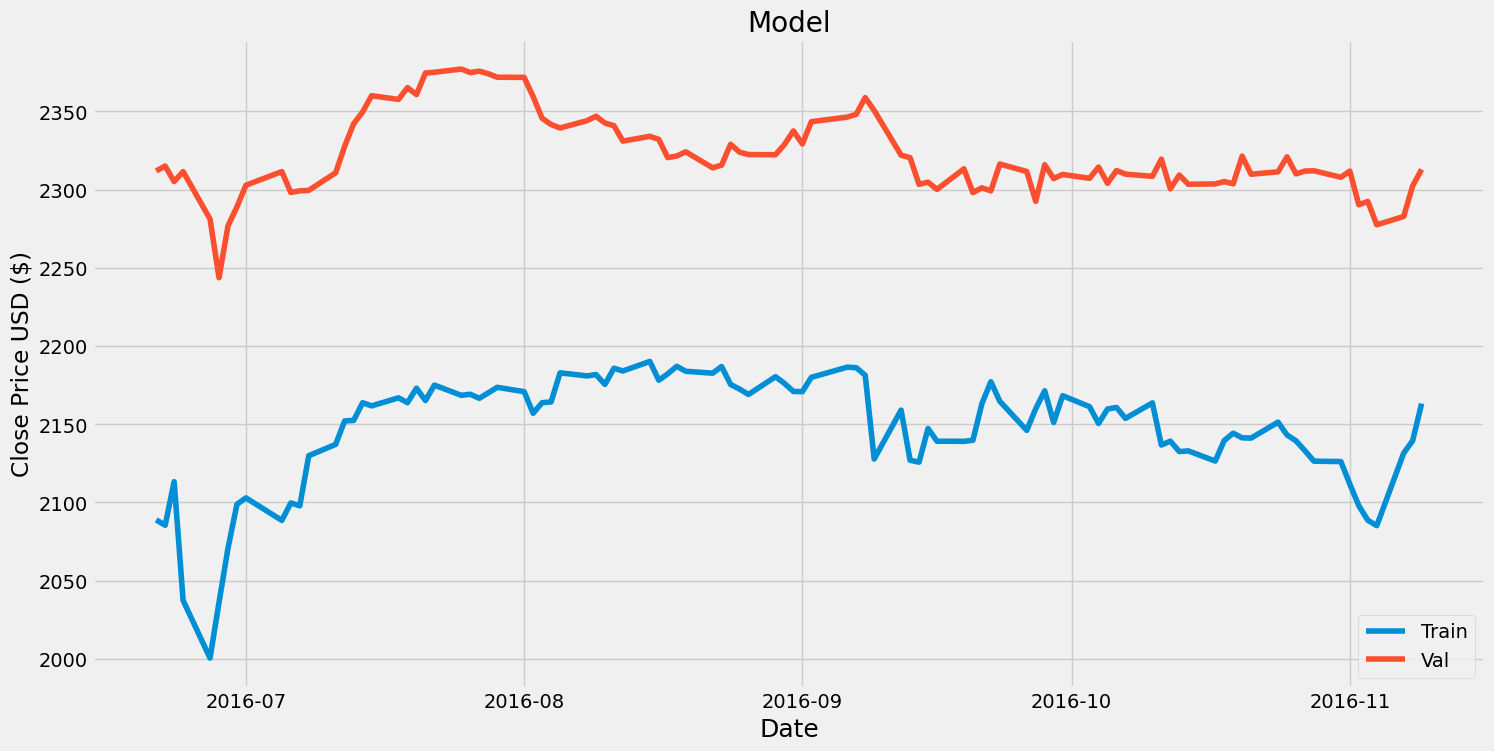

In [ ]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions
#Visualising the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Download the Model Results

import pickle

variables = {
    'data': data,
    'training_data_len': training_data_len,
    'scaler': scaler,
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'predictions': predictions,
    'rmse': rmse,
    'mae': mae,
    'mape': mape,
    'amape': amape,
    'opt_learning_rate': opt_learning_rate,
    'opt_epochs': opt_epochs,
    'opt_batch_size': opt_batch_size,
    'opt_dropout': opt_dropout,
    'opt_activation_function': opt_activation_function,
    'opt_optimizer': opt_optimizer.__name__,
    'opt_neurons_1': opt_neurons_1,
    'opt dense neuron 1': opt_neurons_3,
    'opt_dense neuron 2': opt_neurons_4,
    'opt_l2_lambda': opt_l2_lambda

}

with open('gru_single_400.pickle', 'wb') as f:
    pickle.dump(variables, f)


